# **Preuve de concept** : YOLOV9 pour la classification des races de chiens du Stanford Dogs Dataset

In [ ]:
# Mise en place du notebook
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import glob
from IPython.display import Image, display
from transformers import pipeline
from imageio import imread
from PIL import Image
import cv2
import time
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, GlobalAveragePooling2D, Dense, Dropout, Lambda
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras.optimizers.legacy import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
import pickle

In [ ]:
# Fonctions
def dogs_train_test_split (class_names, new_directory, train_dir, val_dir, test_dir):
  """Fonction pour split les dossiers en train, test et validation set"""

  for class_name in tqdm(class_names, desc="Traitement des données"):
    # Chemin complet vers le dossier de chaque race
    class_dir = os.path.join(new_directory, class_name)
    # Liste des noms de fichiers dans le dossier de chaque race
    files = os.listdir(class_dir)
    # Diviser les fichiers train, validation et test
    train_files, test_val_files = train_test_split(files, test_size=0.2, random_state=0)
    val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=0)
    # Déplacer les fichiers correspondants dans les dossiers de train, validation et test
    for file in train_files:
      src = os.path.join(class_dir, file)
      dst = os.path.join(train_dir, class_name, file)
      os.makedirs(os.path.dirname(dst), exist_ok=True)
      shutil.move(src, dst)
    for file in val_files:
      src = os.path.join(class_dir, file)
      dst = os.path.join(val_dir, class_name, file)
      os.makedirs(os.path.dirname(dst), exist_ok=True)
      shutil.move(src, dst)
    for file in test_files:
      src = os.path.join(class_dir, file)
      dst = os.path.join(test_dir, class_name, file)
      os.makedirs(os.path.dirname(dst), exist_ok=True)
      shutil.move(src, dst)
  # Supprimer tous les dossiers qui ne sont pas train, test ou validation
  for folder in os.listdir(new_directory):
    if folder not in ['train', 'test', 'validation']:
      shutil.rmtree(os.path.join(new_directory, folder))

  return print("Données déplacées avec succès en ensembles d'entraînement, de validation et de test.")

def create_label_content(label, image_width, image_height):
  """Fonction pour créer le contenu du fichier de label"""
  # Définir les coordonnées de la boîte englobante pour l'image entière
  x_center, y_center = 0.5, 0.5
  width, height = 1.0, 1.0
  # Créer le contenu du fichier de label
  label_content = f"{label} {x_center} {y_center} {width} {height}\n"
  return label_content

def get_image_dimensions(image_path):
  """Fonction pour obtenir les dimensions de l'image"""
  # Charger l'image avec OpenCV
  image = cv2.imread(image_path)
  # Vérifier si l'image est chargée correctement
  if image is not None:
    # Obtenir les dimensions de l'image
    image_height, image_width, _ = image.shape
    return image_width, image_height

def move_images_to_images_folder(root_dir):
  """Fonction pour déplacer les images vers le dossier images"""
  # Créer le dossier "images" s'il n'existe pas déjà
  images_dir = os.path.join(root_dir)
  # Parcourir tous les sous-dossiers dans le répertoire racine
  for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    # Vérifier si c'est un dossier
    if os.path.isdir(class_dir):
      # Parcourir toutes les images dans le dossier de classe
      for image_file in os.listdir(class_dir):
        # Chemin complet de l'image actuelle
        image_path = os.path.join(class_dir, image_file)
        # Déplacer l'image vers le dossier "images"
        shutil.move(image_path, images_dir)

def labels_txt(root_dir_train, labels_folder_train, root_dir_test, labels_folder_test, root_dir_validation, labels_folder_validation):
  """Fonction pour définir les labels en fonction des dossiers (noms de races de chiens)
  et création du contenu du fichier texte : label + localisation du chien sur l'image"""
  # Parcourir les dossiers de chaque ensemble de données
  for root_dir, labels_folder in [(root_dir_train, labels_folder_train), (root_dir_test, labels_folder_test), (root_dir_validation, labels_folder_validation)]:
    # Parcourir tous les dossiers dans le répertoire racine
    label = 0
    for class_name in os.listdir(root_dir):
      # Chemin vers le dossier de chaque race de chien
      path_class = os.path.join(root_dir, class_name)
      # Parcourir toutes les images dans le dossier de la race de chien
      for image_file in os.listdir(path_class):
        # Créer le chemin d'accès complet de l'image
        image_path = os.path.join(path_class, image_file)
        # Récupérer les dimensions de l'image
        image_width, image_height = get_image_dimensions(image_path)
        # Créer le contenu du fichier de label
        label_content = create_label_content(label, image_width, image_height)
        # Créer le chemin d'accès et le nom du fichier de label
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(labels_folder, label_file)
        # Écrire le contenu dans le fichier de label
        with open(label_path, 'w') as f:
          f.write(label_content)
      label = label + 1

def remove_empty_folders(directory):
  """Fonction pour supprimer des dossiers vides"""
  # Parcourir tous les sous-dossiers dans le répertoire donné
  for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    # Vérifier si l'élément est un dossier
    if os.path.isdir(item_path):
      # Vérifier si le dossier est vide
      if not os.listdir(item_path):
        # Supprimer le dossier vide
        os.rmdir(item_path)

def eval_model(model, test_loss, test_accuracy, model_history):
    """Fonction pour évaluer le modèle
    avec graphiques (courbe de perte et courbe d'apprentissage)"""
    # Afficher la précision du modèle sur les données de test
    print(f'Accuracy sur les données de test : {test_accuracy*100:.2f}%')

    # Afficher les courbes d'apprentissage (perte et précision)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'], label="Perte sur les données 'entraînement")
    plt.plot(model_history.history['val_loss'], label='Perte sur les données de validation')
    plt.legend()
    plt.title('Courbe de Perte')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['accuracy'], label="Accuracy sur les données d'entraînement")
    plt.plot(model_history.history['val_accuracy'], label='Accuracy sur les données de validation')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

def score(df_results, model_name, accuracy, loss, temps_execution):
    """Fonction pour enregistrer les différentes métriques des modèles dans un DataFrame"""
    # Ajouter les résultats du modèle au DataFrame global en supprimant les potentiels doublons
    df_results.loc[df_results.shape[0]] = [model_name, accuracy, loss, temps_execution]
    df_results = df_results.drop_duplicates(subset=['Model'])

## 1. Analyse exploratoire du dataset

In [ ]:
# Chemin vers le répertoire d'images
images_dir = '/content/gdrive/MyDrive/P7/Images'

# Boucle pour récupérer les noms d'images et les labels
image_files = []
labels = []

for root, dirs, images in os.walk(images_dir):
    for image in images:
        image_files.append(os.path.join(root, image))
        labels.append(os.path.basename(root).split('-')[1])

# Mise en place du DataFrame
df_dogs = pd.DataFrame({'image_path': image_files, 'label': labels})
df_dogs.head()

,image_path,label
0,/content/gdrive/MyDrive/P7/Images/n02085936-Ma...,Maltese_dog
1,/content/gdrive/MyDrive/P7/Images/n02085936-Ma...,Maltese_dog
2,/content/gdrive/MyDrive/P7/Images/n02085936-Ma...,Maltese_dog
3,/content/gdrive/MyDrive/P7/Images/n02085936-Ma...,Maltese_dog
4,/content/gdrive/MyDrive/P7/Images/n02085936-Ma...,Maltese_dog


In [ ]:
# Initialiser un dictionnaire pour stocker le nombre d'images par étiquette
label_counts = {}

# Boucle pour récupérer les noms d'images et les labels
for root, dirs, images in os.walk(images_dir):
    for image in images:
        label = os.path.basename(root).split('-')[1]
        label_counts[label] = label_counts.get(label, 0) + 1

# Convertir le dictionnaire en DataFrame
df_label_counts = pd.DataFrame(label_counts.items(), columns=['Label', "Nombre d'images"])

# Afficher le DataFrame
print("Nombre d'images par labels :")
df_label_counts

Nombre d'images par labels :


,Label,Nombre d'images
0,Maltese_dog,252
1,Chihuahua,152
2,Japanese_spaniel,185
3,basset,175
4,papillon,196
...,...,...
115,Cardigan,155
116,African_hunting_dog,169
117,dingo,156
118,miniature_poodle,155


In [ ]:
# Afficher un describe
label_statistics = df_label_counts.describe()

# Ajouter une colonne pour le total d'images
label_statistics.loc['Total'] = df_label_counts["Nombre d'images"].sum()

# Afficher le tableau des statistiques
print("Statistiques :")
label_statistics

Statistiques :


,Nombre d'images
count,120.000000
mean,171.500000
std,23.220898
min,148.000000
25%,152.750000
50%,159.500000
75%,186.250000
max,252.000000
Total,20580.000000


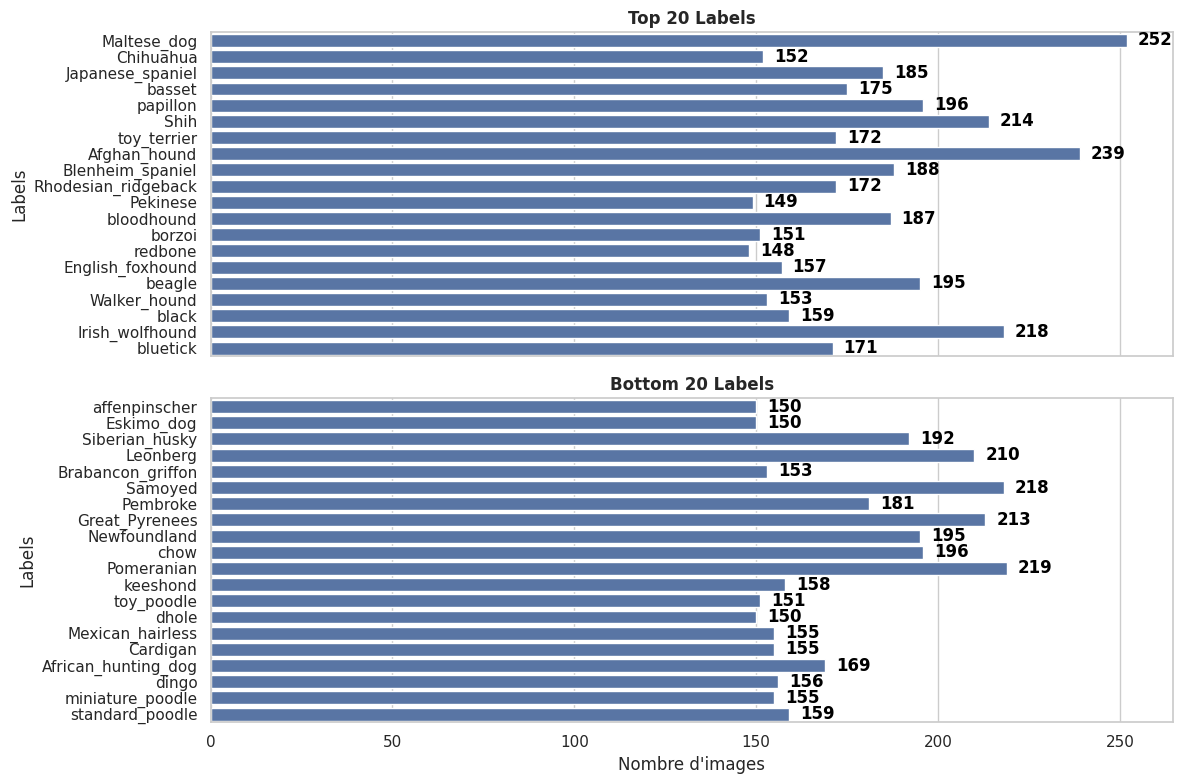

In [ ]:
# Sélectionner les 20 premières et les 20 dernières étiquettes
top_labels = df_label_counts.head(20)
bottom_labels = df_label_counts.tail(20)

# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Tracer les graphiques des 20 premières étiquettes
sns.set(style="whitegrid")
sns.barplot(x=top_labels["Nombre d'images"], y=top_labels["Label"], ax=ax1)
ax1.set_ylabel('Labels')
ax1.set_xlabel("Nombre d'images")
ax1.set_title("Top 20 Labels", fontdict={'fontweight':'bold', 'fontsize':12})

# Ajouter des annotations aux barres
for i, v in enumerate(top_labels["Nombre d'images"]):
    ax1.text(v + 3, i, str(v), color='black', fontweight='bold', va='center')

# Tracer les graphiques des 20 dernières étiquettes
sns.barplot(x=bottom_labels["Nombre d'images"], y=bottom_labels["Label"], ax=ax2)
ax2.set_ylabel('Labels')
ax2.set_xlabel("Nombre d'images")
ax2.set_title("Bottom 20 Labels", fontdict={'fontweight':'bold', 'fontsize':12})

# Ajouter des annotations aux barres
for i, v in enumerate(bottom_labels["Nombre d'images"]):
    ax2.text(v + 3, i, str(v), color='black', fontweight='bold', va='center')

plt.tight_layout()
plt.show()

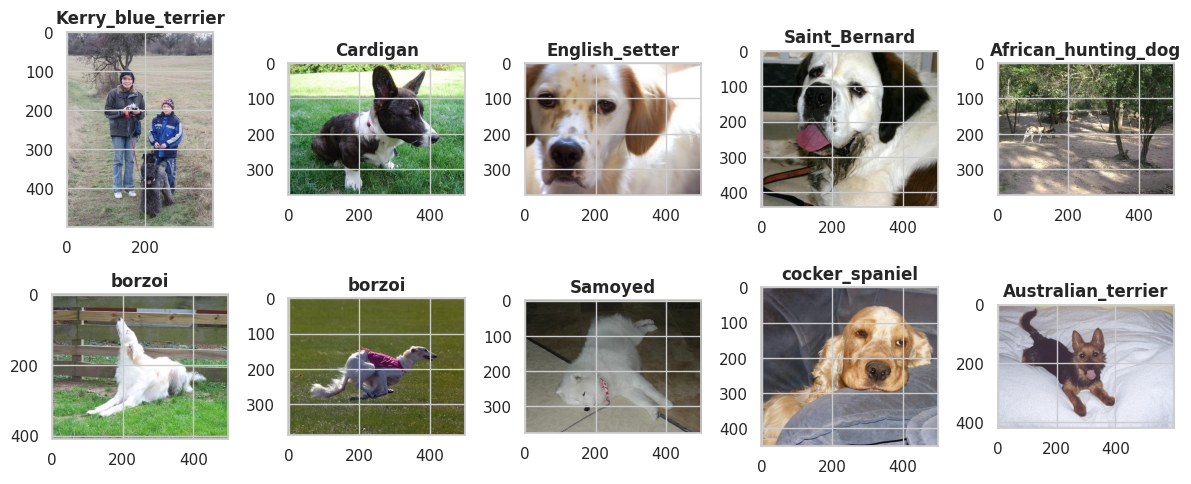

In [ ]:
# Sélectionner aléatoirement quelques lignes du DataFrame
sample_df = df_dogs.sample(10)

# Afficher les images et leurs étiquettes
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(sample_df.iloc[i]['image_path'])
    plt.imshow(img)
    plt.title(sample_df.iloc[i]['label'], fontdict={'fontweight':'bold'})
    plt.tight_layout()
plt.show()

## 2. Nettoyage du dataset

Nous allons d'abord choisir 15 races de chiens afin de réduire le temps de calcul.

In [ ]:
# Créer un dossier pour stocker les 15 races de chiens sélectionnées
dogs_selection_dir = "/content/gdrive/MyDrive/P7/dogs_selection"
os.makedirs(dogs_selection_dir, exist_ok=True)

# Sélectionner 15 races de chiens parmi les 120 disponibles
selected_dirs = ['Bernese_mountain_dog', 'boxer', 'briard',
                 'Brittany_spaniel', 'bull_mastiff', 'Doberman',
                 'EntleBucher', 'French_bulldog', 'Gordon_setter',
                 'Greater_Swiss_Mountain_dog', 'Irish_setter', 'Rottweiler',
                 'Samoyed', 'Tibetan_terrier', 'vizsla']

# Copier les dossiers sélectionnés dans le nouveau répertoire
for class_name in os.listdir(images_dir):
    # Extraire le nom de la race du dossier
    dog_name = class_name.split('-')[1]
    if dog_name in selected_dirs:
        # Chemin source et destination
        src = os.path.join(images_dir, class_name)
        dst = os.path.join(dogs_selection_dir, dog_name)
        # Copier le dossier avec le nouveau nom
        shutil.copytree(src, dst)

### 2.1 Préparation des données pour la baseline

In [ ]:
# Création d'un dossier dans lequel coller les différents dossiers des 15 races de chiens pour le modèle baseline
new_directory = "/content/gdrive/MyDrive/P7/dogs_baseline"

# Copier les dossiers
source_dir = "/content/gdrive/MyDrive/P7/dogs_selection"
shutil.copytree(source_dir, new_directory)

'/content/gdrive/MyDrive/P7/dogs_baseline'

In [ ]:
# Liste des noms de dossiers correspondant à chaque race de chien
class_names = os.listdir(new_directory)

# Créer des dossiers pour les données d'entraînement, de validation et de test
train_dir = os.path.join(new_directory, 'train')
test_dir = os.path.join(new_directory, 'test')
val_dir = os.path.join(new_directory, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Séparation en train/ test/ validation set
dogs_train_test_split (class_names, new_directory, train_dir, val_dir, test_dir)

Traitement des données: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]

Données déplacées avec succès en ensembles d'entraînement, de validation et de test.


### 2.2 Préparation des données pour le modèle YOLOV9

Avant d'utiliser YOLOV9 pour la classification des images, nous allons d'abord l'appliquer à la détection des chiens sur les images.

Ensuite, nous enregistrerons les parties d'intérêt détectées dans un dossier distinct, où nous les vérifierons manuellement pour confirmer si elles correspondent effectivement à la race de chien recherchée, surtout dans le cas d'images contenant plusieurs chiens.

Puis, nous procéderons au détourage des images afin de réduire le bruit présent sur celles-ci.

#### 2.2.1 Détection des chiens avec YOLOV9

In [ ]:
!nvidia-smi

Fri Apr 19 13:47:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

# Check PyTorch GPU availability
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Is Available: {torch.cuda.is_available()}")
else:
    print("GPU is not available.")

GPU Name: Tesla T4
GPU Is Available: True


In [ ]:
# Répertoire
%cd /content/gdrive/MyDrive/P7

/content/gdrive/MyDrive/P7


In [ ]:
# Clone du GitHub avec le modèle YOLOV9
# !git clone --recursive https://github.com/WongKinYiu/yolov9.git
%cd yolov9
# !pip install -r requirements.txt

/content/gdrive/MyDrive/P7/yolov9


In [ ]:
# Téléchargement du modèle
# !wget -P /content/gdrive/MyDrive/P7/yolov9 https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt

#### 2.2.2 Test de la detection sur une image

In [ ]:
# Chemin de l'image choisi
path_img = "/content/gdrive/MyDrive/P7/Images/n02088094-Afghan_hound/n02088094_294.jpg"

# Commande pour détecter des objets dans l'image
!python detect.py --weights "/content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt" --source "{path_img}" --device cpu

detect: weights=['/content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt'], source=/content/gdrive/MyDrive/P7/Images/n02088094-Afghan_hound/n02088094_294.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=cpu, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-88-g03f920b Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients
image 1/1 /content/gdrive/MyDrive/P7/Images/n02088094-Afghan_hound/n02088094_294.jpg: 640x640 1 person, 2 dogs, 3939.8ms
Speed: 2.4ms pre-process, 3939.8ms inference, 19.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


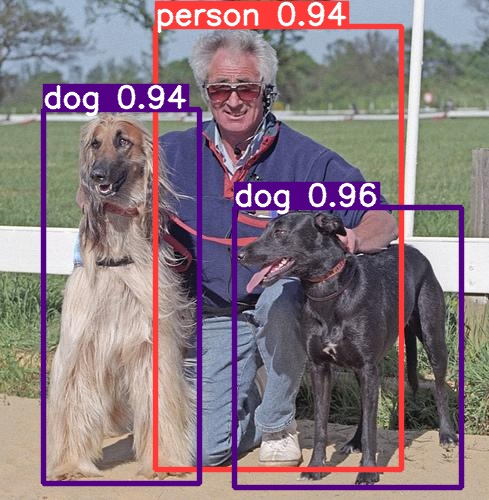

In [ ]:
# Afficher l'image
for image_path in glob.glob(r'/content/gdrive/MyDrive/P7/yolov9/runs/detect/exp2/*.jpg')[:1]:
    display(Image(filename=image_path, width=200))

#### 2.2.3 Détection des chiens sur les images avec crops des images


In [ ]:
# Chemin vers le répertoire racine contenant les dossiers par race de chien
root_dir = "/content/gdrive/MyDrive/P7/dogs_selection"

# Création d'un dossier dans lequel coller les différents dossiers des races de chiens
new_directory = "/content/gdrive/MyDrive/P7/dogs_detection"
os.makedirs(new_directory, exist_ok=True)

# Fixer le nombre d'expériences de départ
n_exp = 2

# Parcourir tous les dossiers dans le répertoire racine
for class_name in os.listdir(root_dir):
    # Chemin vers le dossier de chaque race de chien
    path_class = os.path.join(root_dir, class_name)
    # Exécuter detect.py sur la race de chien ciblé
    !python detect.py --weights "/content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt" --source "{path_class}" --device cpu --save-crop
    # Récupérer les images et les copier dans le dossier
    # Chemin du dossier source à copier
    source_dir = f"/content/gdrive/MyDrive/P7/yolov9/runs/detect/exp{n_exp+1}/crops/dog"
    # Chemin de destination où le dossier source est collé
    destination_dir = os.path.join(new_directory, class_name)
    # Copier le dossier source vers le dossier de destination
    shutil.copytree(source_dir, destination_dir)
    # Rajouter 1 au nombre d'expérience
    n_exp = n_exp + 1

detect: weights=['/content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt'], source=/content/gdrive/MyDrive/P7/dogs_selection/Tibetan_terrier, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=cpu, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-88-g03f920b Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients
image 1/206 /content/gdrive/MyDrive/P7/dogs_selection/Tibetan_terrier/n02097474_1023.jpg: 448x640 1 dog, 2727.0ms
image 2/206 /content/gdrive/MyDrive/P7/dogs_selection/Tibetan_terrier/n02097474_1070.jpg: 448x640 1 dog, 1 potted plant, 3543.7ms
image 3/206 /content/gdrive/MyDrive/P7/dogs_selection/Tibetan_terrier/n02097474_1095.j

#### 2.2.4 Détourage des images

In [ ]:
# Changer le répertoire de travail
%cd /content/gdrive/MyDrive/P7

# Clone du git de RMBG
!git clone --recursive https://github.com/chenxwh/cog-RMBG.git

# Changer le répertoire de travail
%cd /content/gdrive/MyDrive/P7/cog-RMBG

# Installation du requirements.txt
!pip install -r requirements.txt

/content/gdrive/MyDrive/P7
fatal: destination path 'cog-RMBG' already exists and is not an empty directory.
/content/gdrive/MyDrive/P7/cog-RMBG


In [ ]:
import torch
from PIL import Image
from huggingface_hub import hf_hub_download
from cog import BasePredictor, Input, Path
from briarmbg import BriaRMBG
from utilities import preprocess_image, postprocess_image
from imageio import imread

# Chemin vers le répertoire racine contenant les dossiers par race de chien
root_dir = "/content/gdrive/MyDrive/P7/dogs_detection"

# Création d'un dossier dans lequel coller les différents dossiers des races de chiens
new_directory = "/content/gdrive/MyDrive/P7/dogs_RMBG"
os.makedirs(new_directory, exist_ok=True)

model_path = hf_hub_download("briaai/RMBG-1.4", 'model.pth')

net = BriaRMBG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load(model_path, map_location=device))
net.to(device)
net.eval()

for class_name in os.listdir(root_dir):
    # Chemin vers le dossier de chaque race de chien
    path_class = os.path.join(root_dir, class_name)

    # Boucle sur chaque image dans le dossier de la race de chien
    for image_name in os.listdir(path_class):
        # Chemin complet de l'image
        image_path = os.path.join(path_class, image_name)

        model_input_size = [1024, 1024]
        orig_im = imread(image_path)
        orig_im_size = orig_im.shape[0:2]
        image = preprocess_image(orig_im, model_input_size).to(device)

        result = net(image)

        result_image = postprocess_image(result[0][0], orig_im_size)

        pil_im = Image.fromarray(result_image)
        no_bg_image = Image.new("RGBA", pil_im.size, (0, 0, 0, 0))
        orig_image = Image.open(image_path)
        no_bg_image.paste(orig_image, mask=pil_im)

        # Construire le chemin de destination
        destination_path = os.path.join(new_directory, class_name)
        os.makedirs(destination_path, exist_ok=True)

        # Enregistrer l'image dans le nouveau répertoire
        output_image_path = os.path.join(destination_path, image_name.split('.')[0] + '_RMBG.png')
        no_bg_image.save(output_image_path)

<ipython-input-13-0ce281668548>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  orig_im = imread(image_path)


### 2.3 Dataset split sans détourage

In [ ]:
# Création d'un dossier dans lequel coller les différents dossiers des 15 races de chiens pour le modèle baseline
new_directory = "/content/gdrive/MyDrive/P7/split_dogs_15"

# Copier les dossiers
source_dir = "/content/gdrive/MyDrive/P7/dogs_detection"
shutil.copytree(source_dir, new_directory)

'/content/gdrive/MyDrive/P7/split_dogs_15'

In [ ]:
# Liste des noms de dossiers correspondant à chaque race de chien
class_names = os.listdir(new_directory)

# Créer des dossiers pour les données d'entraînement, de validation et de test
train_dir = os.path.join(new_directory, 'train/images')
test_dir = os.path.join(new_directory, 'test/images')
val_dir = os.path.join(new_directory, 'validation/images')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Séparation en train/ test/ validation set
dogs_train_test_split (class_names, new_directory, train_dir, val_dir, test_dir)

Traitement des données: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]

Données déplacées avec succès en ensembles d'entraînement, de validation et de test.


### 2.4 Dataset split avec détourage

In [ ]:
# Création d'un dossier dans lequel coller les différents dossiers des 15 races de chiens pour le modèle baseline
new_directory = "/content/gdrive/MyDrive/P7/split_dogs_cutout_15"

# Copier les dossiers
source_dir = "/content/gdrive/MyDrive/P7/dogs_RMBG"
shutil.copytree(source_dir, new_directory)

'/content/gdrive/MyDrive/P7/split_dogs_cutout_15'

In [ ]:
# Liste des noms de dossiers correspondant à chaque race de chien
class_names = os.listdir(new_directory)

# Créer des dossiers pour les données d'entraînement, de validation et de test
train_dir = os.path.join(new_directory, 'train/images')
test_dir = os.path.join(new_directory, 'test/images')
val_dir = os.path.join(new_directory, 'validation/images')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Séparation en train/ test/ validation set
dogs_train_test_split (class_names, new_directory, train_dir, val_dir, test_dir)

Traitement des données: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Données déplacées avec succès en ensembles d'entraînement, de validation et de test.


### 2.5 Création des fichiers labels

Pour pouvoir entraîner YOLOV9 nous devons avoir un fichier .txt label pour chacune des images.

Ce fichier déterminera la race du chien mais aussi l'emplacement de la box de détection. Dans notre cas, nous avons "zoomé" sur les chiens, donc la box sera représentée par toute l'image.

Pour les images non détourées :

In [ ]:
# Chemin vers les répertoires racines contenant les dossiers par race de chien
root_dir_train = "/content/gdrive/MyDrive/P7/split_dogs_15/train/images"
root_dir_test = "/content/gdrive/MyDrive/P7/split_dogs_15/test/images"
root_dir_validation = "/content/gdrive/MyDrive/P7/split_dogs_15/validation/images"

# Chemin des dossiers où enregistrer les fichiers de label
labels_folder_train = "/content/gdrive/MyDrive/P7/split_dogs_15/train/labels"
os.makedirs(labels_folder_train, exist_ok=True)
labels_folder_test = "/content/gdrive/MyDrive/P7/split_dogs_15/test/labels"
os.makedirs(labels_folder_test, exist_ok=True)
labels_folder_validation = "/content/gdrive/MyDrive/P7/split_dogs_15/validation/labels"
os.makedirs(labels_folder_validation, exist_ok=True)

# Créer les fichiers .txt avec la fonction préalablement crée
labels_txt(root_dir_train, labels_folder_train, root_dir_test, labels_folder_test, root_dir_validation, labels_folder_validation)

In [ ]:
# Déplacer les images vers le dossier "images" pour chaque ensemble de données
move_images_to_images_folder(root_dir_train)
move_images_to_images_folder(root_dir_test)
move_images_to_images_folder(root_dir_validation)

# Suppression
remove_empty_folders(root_dir_train)
remove_empty_folders(root_dir_test)
remove_empty_folders(root_dir_validation)

Pour les images détourées :

In [ ]:
# Chemin vers les répertoires racines contenant les dossiers par race de chien
root_dir_train = "/content/gdrive/MyDrive/P7/split_dogs_cutout_15/train/images"
root_dir_test = "/content/gdrive/MyDrive/P7/split_dogs_cutout_15/test/images"
root_dir_validation = "/content/gdrive/MyDrive/P7/split_dogs_cutout_15/validation/images"

# Chemin des dossiers où enregistrer les fichiers de label
labels_folder_train = "/content/gdrive/MyDrive/P7/split_dogs_cutout_15/train/labels"
os.makedirs(labels_folder_train, exist_ok=True)
labels_folder_test = "/content/gdrive/MyDrive/P7/split_dogs_cutout_15/test/labels"
os.makedirs(labels_folder_test, exist_ok=True)
labels_folder_validation = "/content/gdrive/MyDrive/P7/split_dogs_cutout_15/validation/labels"
os.makedirs(labels_folder_validation, exist_ok=True)

# Créer les fichiers .txt avec la fonction préalablement crée
labels_txt(root_dir_train, labels_folder_train, root_dir_test, labels_folder_test, root_dir_validation, labels_folder_validation)

In [ ]:
# Déplacer les images vers le dossier "images" pour chaque ensemble de données
move_images_to_images_folder(root_dir_train)
move_images_to_images_folder(root_dir_test)
move_images_to_images_folder(root_dir_validation)

# Suppression
remove_empty_folders(root_dir_train)
remove_empty_folders(root_dir_test)
remove_empty_folders(root_dir_validation)

## 3. Modèle baseline

In [ ]:
# Définition des chemins vers les répertoires
train_dir = '/content/gdrive/MyDrive/P7/dogs_baseline/train'
test_dir = '/content/gdrive/MyDrive/P7/dogs_baseline/test'
validation_dir = '/content/gdrive/MyDrive/P7/dogs_baseline/validation'

In [ ]:
# Classes
selection_classes = ['Bernese_mountain_dog', 'boxer', 'briard',
                 'Brittany_spaniel', 'bull_mastiff', 'Doberman',
                 'EntleBucher', 'French_bulldog', 'Gordon_setter',
                 'Greater_Swiss_Mountain_dog', 'Irish_setter', 'Rottweiler',
                 'Samoyed', 'Tibetan_terrier', 'vizsla']

# Liste des sous-répertoires dans le répertoire d'entraînement
class_names = os.listdir(train_dir)

# Nombre de classes (nombre de sous-répertoires)
nb_classes = len(class_names)

In [ ]:
# Créer un objet ImageDataGenerator pour la normalisation
datagen = ImageDataGenerator(rescale=1./255,
                             preprocessing_function=preprocess_input)

# Créer un objet ImageDataGenerator pour la normalisation et l'augmentation de données
datagen_aug = ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 shear_range=30,
                                 preprocessing_function=preprocess_input)

In [ ]:
# Préparer le modèle de base
base_model = VGG16(include_top=False,
                   pooling=None,
                   input_shape=(224, 224, 3),
                   weights="imagenet")

# Geler les layers du modèle déjà pré-entrainé pour éviter l'overfitting
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(nb_classes, activation='softmax')(x)
model_vgg16 = Model(base_model.input, output)

# Compiler le modèle avec un optimisateur, une fonction de perte et des métriques
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_vgg16.compile(optimizer=adam,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg16.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Entraîner le modèle sur les données d'entraînement
epochs = 40

# Enregistrement du temps actuel
start_time = time.time()

history_vgg16 = model_vgg16.fit(datagen_aug.flow_from_directory(train_dir,
                                                                batch_size=40,
                                                                target_size=(224, 224),
                                                                class_mode='categorical',
                                                                classes=selection_classes),
                                epochs = epochs,
                                validation_data = datagen_aug.flow_from_directory(validation_dir,
                                                                                  batch_size=40,
                                                                                  target_size=(224, 224),
                                                                                  class_mode='categorical',
                                                                                  classes=selection_classes),
                                shuffle = True,
                                callbacks=EarlyStopping(monitor='val_accuracy',patience=10))

# Calcul du temps d'exécution
execution_time = time.time() - start_time

Found 2030 images belonging to 15 classes.
Found 254 images belonging to 15 classes.
Epoch 1/40
51/51 [==============================] - 1720s 34s/step - loss: 2.4554 - accuracy: 0.2236 - val_loss: 2.0952 - val_accuracy: 0.3465
Epoch 2/40
51/51 [==============================] - 41s 796ms/step - loss: 1.8308 - accuracy: 0.4222 - val_loss: 1.7476 - val_accuracy: 0.4409
Epoch 3/40
51/51 [==============================] - 41s 798ms/step - loss: 1.4584 - accuracy: 0.5665 - val_loss: 1.5944 - val_accuracy: 0.5039
Epoch 4/40
51/51 [==============================] - 41s 799ms/step - loss: 1.2048 - accuracy: 0.6773 - val_loss: 1.4455 - val_accuracy: 0.5315
Epoch 5/40
51/51 [==============================] - 41s 808ms/step - loss: 1.0855 - accuracy: 0.6892 - val_loss: 1.5078 - val_accuracy: 0.4921
Epoch 6/40
51/51 [==============================] - 41s 808ms/step - loss: 0.9394 - accuracy: 0.7443 - val_loss: 1.3038 - val_accuracy: 0.5984
Epoch 7/40
51/51 [==============================] - 41s 8

Found 262 images belonging to 15 classes.
7/7 - 2s - loss: 1.0292 - accuracy: 0.6489 - 2s/epoch - 248ms/step
Accuracy sur les données de test : 64.89%


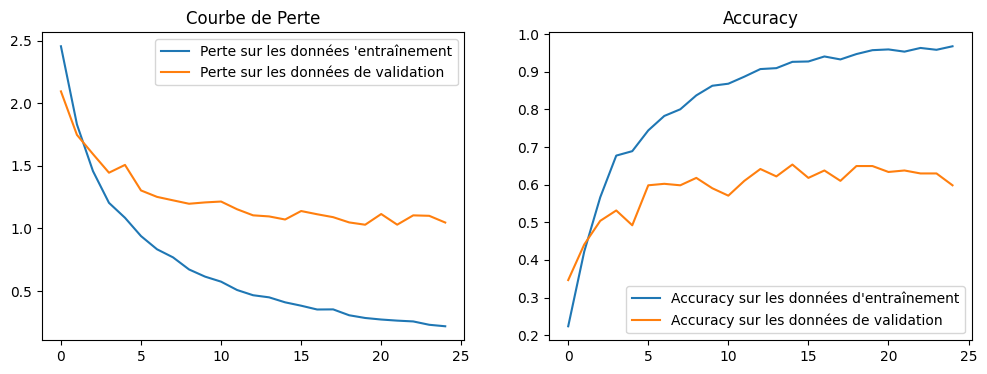

In [ ]:
# Evaluer le modèle sur les données de test
test_loss, test_accuracy = model_vgg16.evaluate(datagen.flow_from_directory(test_dir,
                                                                            batch_size=40,
                                                                            target_size=(224, 224),
                                                                            class_mode='categorical',
                                                                            classes=selection_classes),
                                                verbose=2)

# Evaluation du modèle avec la fonction d'évaluation 'eval_model'
eval_model(model_vgg16, test_loss, test_accuracy, history_vgg16)

In [ ]:
# Créer un DataFrame vide pour stocker les résultats des modèles
df_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss', "Temps d'entraînement du modèle"])

# Enregistrement des scores du modèle
score(df_results, 'model_vgg16', test_accuracy, test_loss, execution_time)

df_results.loc[df_results['Model'] == 'model_vgg16']

,Model,Accuracy,Loss,Temps d'entraînement du modèle
0,model_vgg16,0.648855,1.029194,2816.784914


In [ ]:
# Récupérer le dictionnaire class_index
class_index = {v: k for k, v in datagen_aug.flow_from_directory(train_dir,
                                                                batch_size=40,
                                                                target_size=(224, 224),
                                                                class_mode='categorical',
                                                                classes=selection_classes).class_indices.items()}
class_index

Found 2030 images belonging to 15 classes.


{0: 'Bernese_mountain_dog',
 1: 'boxer',
 2: 'briard',
 3: 'Brittany_spaniel',
 4: 'bull_mastiff',
 5: 'Doberman',
 6: 'EntleBucher',
 7: 'French_bulldog',
 8: 'Gordon_setter',
 9: 'Greater_Swiss_Mountain_dog',
 10: 'Irish_setter',
 11: 'Rottweiler',
 12: 'Samoyed',
 13: 'Tibetan_terrier',
 14: 'vizsla'}

In [ ]:
from tensorflow.keras.preprocessing import image

# Créer une liste pour stocker les prédictions et les étiquettes réelles
predictions_list = []
true_labels_list = []

# Parcourir les sous-dossiers dans le répertoire de test
for class_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_folder)

    # Parcourir les images dans chaque sous-dossier
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Charger l'image et la redimensionner
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normaliser les valeurs des pixels

        # Faire la prédiction
        prediction = model_vgg16.predict(img_array)

        # Ajouter la prédiction et l'étiquette réelle à leurs listes respectives
        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_index[predicted_class_index]  # Obtenir le nom de classe prédit
        true_labels_list.append(class_folder)  # Utiliser le nom de classe réel

        # Pour afficher la prédiction :
        predictions_list.append(predicted_class_name)

# Convertir les listes en tableaux numpy pour une manipulation facile
predictions_array = np.array(predictions_list)
true_labels_array = np.array(true_labels_list)


1/1 [==============================] - 0s 19ms/step
Dimensions du tableau de prédictions : (262,)
Dimensions du tableau d'étiquettes réelles : (262,)


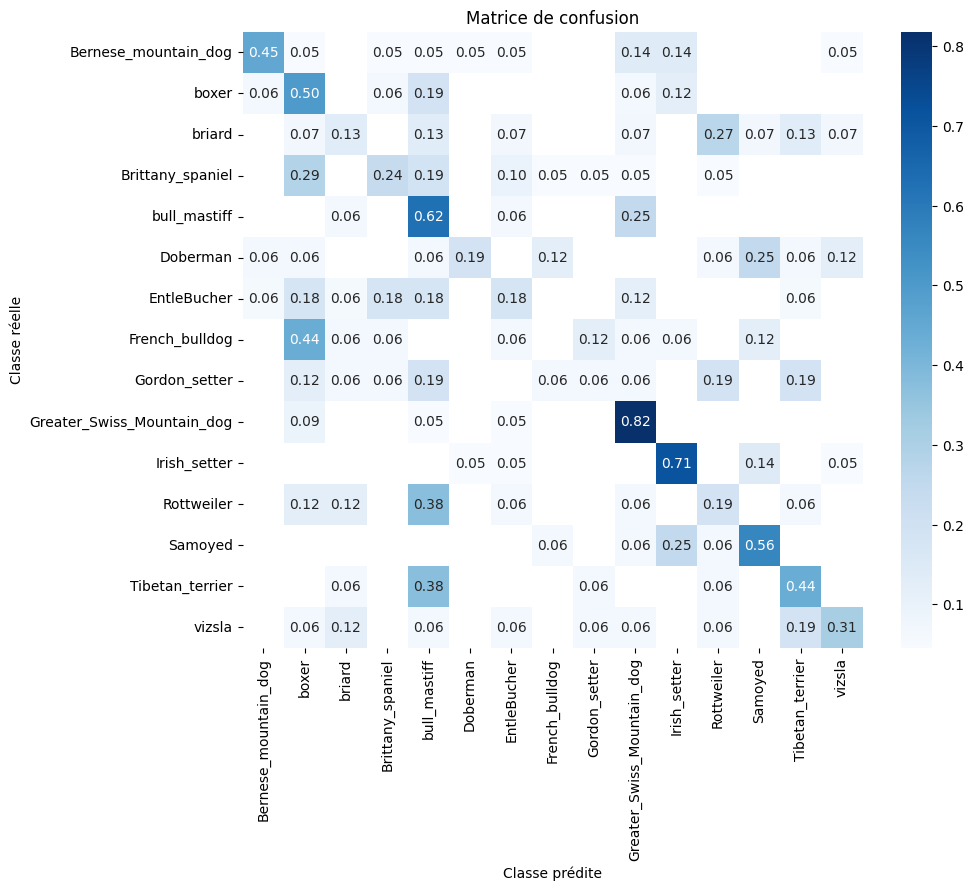

In [ ]:
# Créer la matrice de confusion
conf_matrix = confusion_matrix(true_labels_array, predictions_array)

# Calculez le nombre total d'échantillons dans chaque classe réelle
total_samples_per_class = np.sum(conf_matrix, axis=1)

# Divisez chaque élément de la matrice de confusion par le nombre total d'échantillons correspondant à sa classe réelle
conf_matrix_percent = conf_matrix / total_samples_per_class[:, np.newaxis]

# Convertir les valeurs 0 en NaN
conf_matrix_display = conf_matrix_percent.astype(float)
conf_matrix_display[conf_matrix_percent == 0] = np.nan

# Récupérer les noms des classes à partir du dictionnaire class_index
class_names = [class_index[i] for i in range(len(class_index))]

# Afficher la matrice de confusion avec pourcentage
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_display, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion')
plt.show()

In [ ]:
# Enregistrer le dictionnaire des classes en .pkl
with open('/content/gdrive/MyDrive/P7/index_to_class.pkl', 'wb') as file:
    pickle.dump(class_index, file)

In [ ]:
# Enregistrer le modèle VGG16
model_vgg16.save('/content/gdrive/MyDrive/P7/model_vgg16.h5')
print('Modèle VGG16 correctement enregistré sur Google Drive.')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modèle VGG16 correctement enregistré sur Google Drive.


## 4. Modèle YOLOV9

### 4.1 Entraînement du modèle sur les images non détourées

In [ ]:
!python train_dual.py --workers 8 --batch 10  --img 640 --epochs 70 --data /content/gdrive/MyDrive/P7/yolov9/data.yaml --weights /content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt --device 0 --cfg /content/gdrive/MyDrive/P7/yolov9/models/detect/yolov9_custom.yaml --hyp /content/gdrive/MyDrive/P7/yolov9/data/hyps/hyp.scratch-high.yaml

2024-04-18 07:14:44.562381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 07:14:44.562437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 07:14:44.563741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 07:14:45.609184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train_dual: weights=/content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt, cfg=/content/gdrive/MyDrive/P7/yolov9/models/detect/yolov9_custom.yaml, data=/content/gdrive/MyDrive/P7/yolov9/data.yaml, hyp=/content/gdrive/MyDrive/P7/yolov9/data/hyps/hyp.

### 4.2 Evaluation du modèle

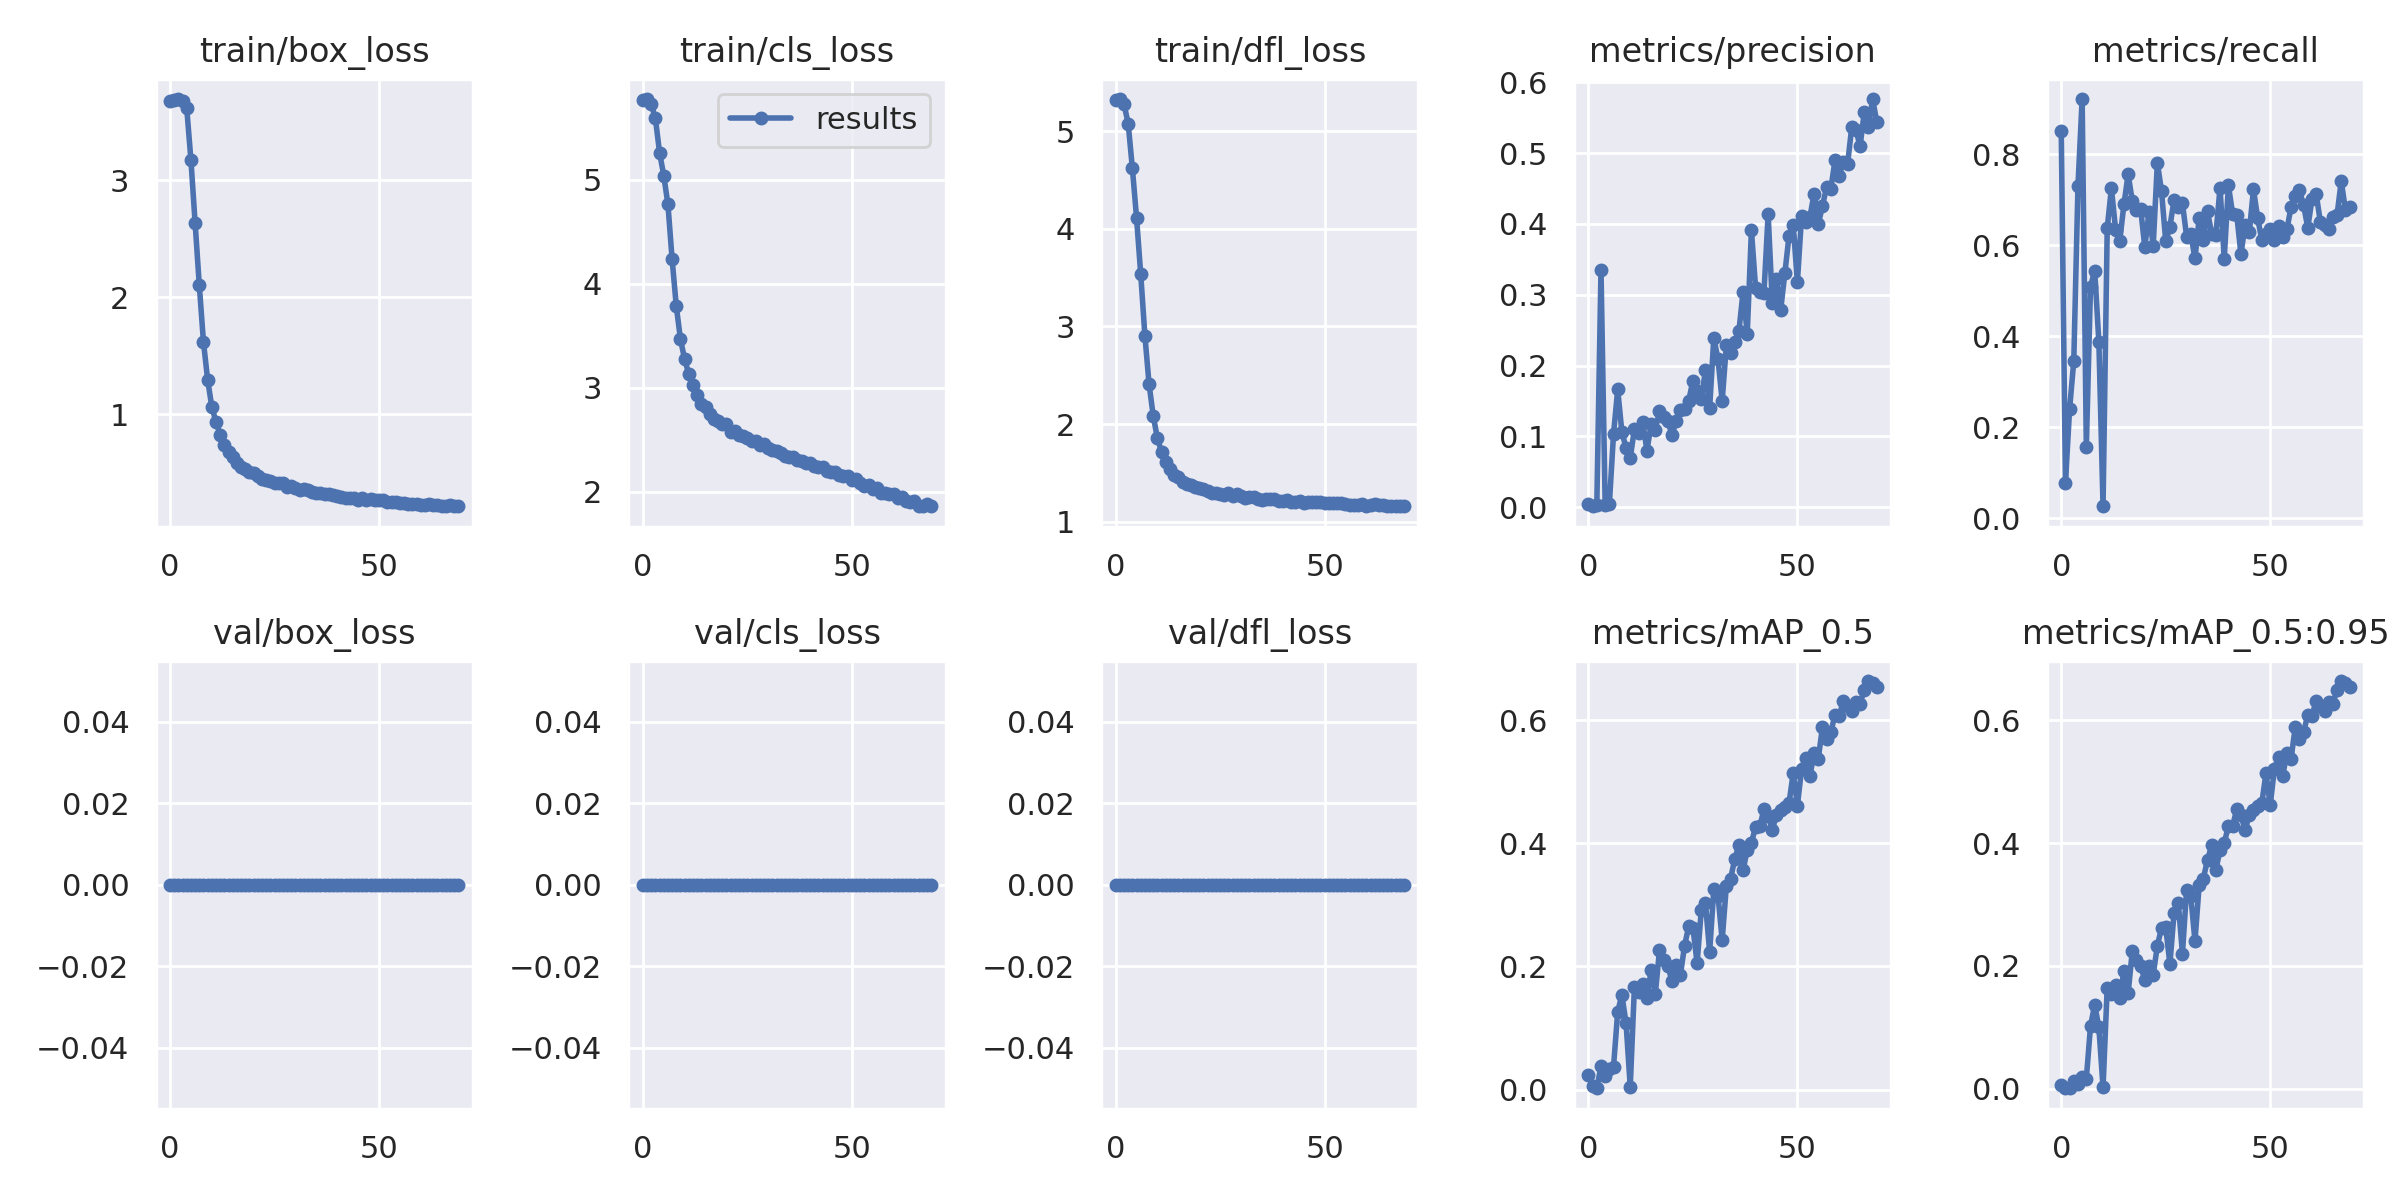

In [ ]:
# Affichage des résultats
Image(filename=f"/content/gdrive/MyDrive/P7/yolov9/runs/train/exp4/results.png", width=1000)

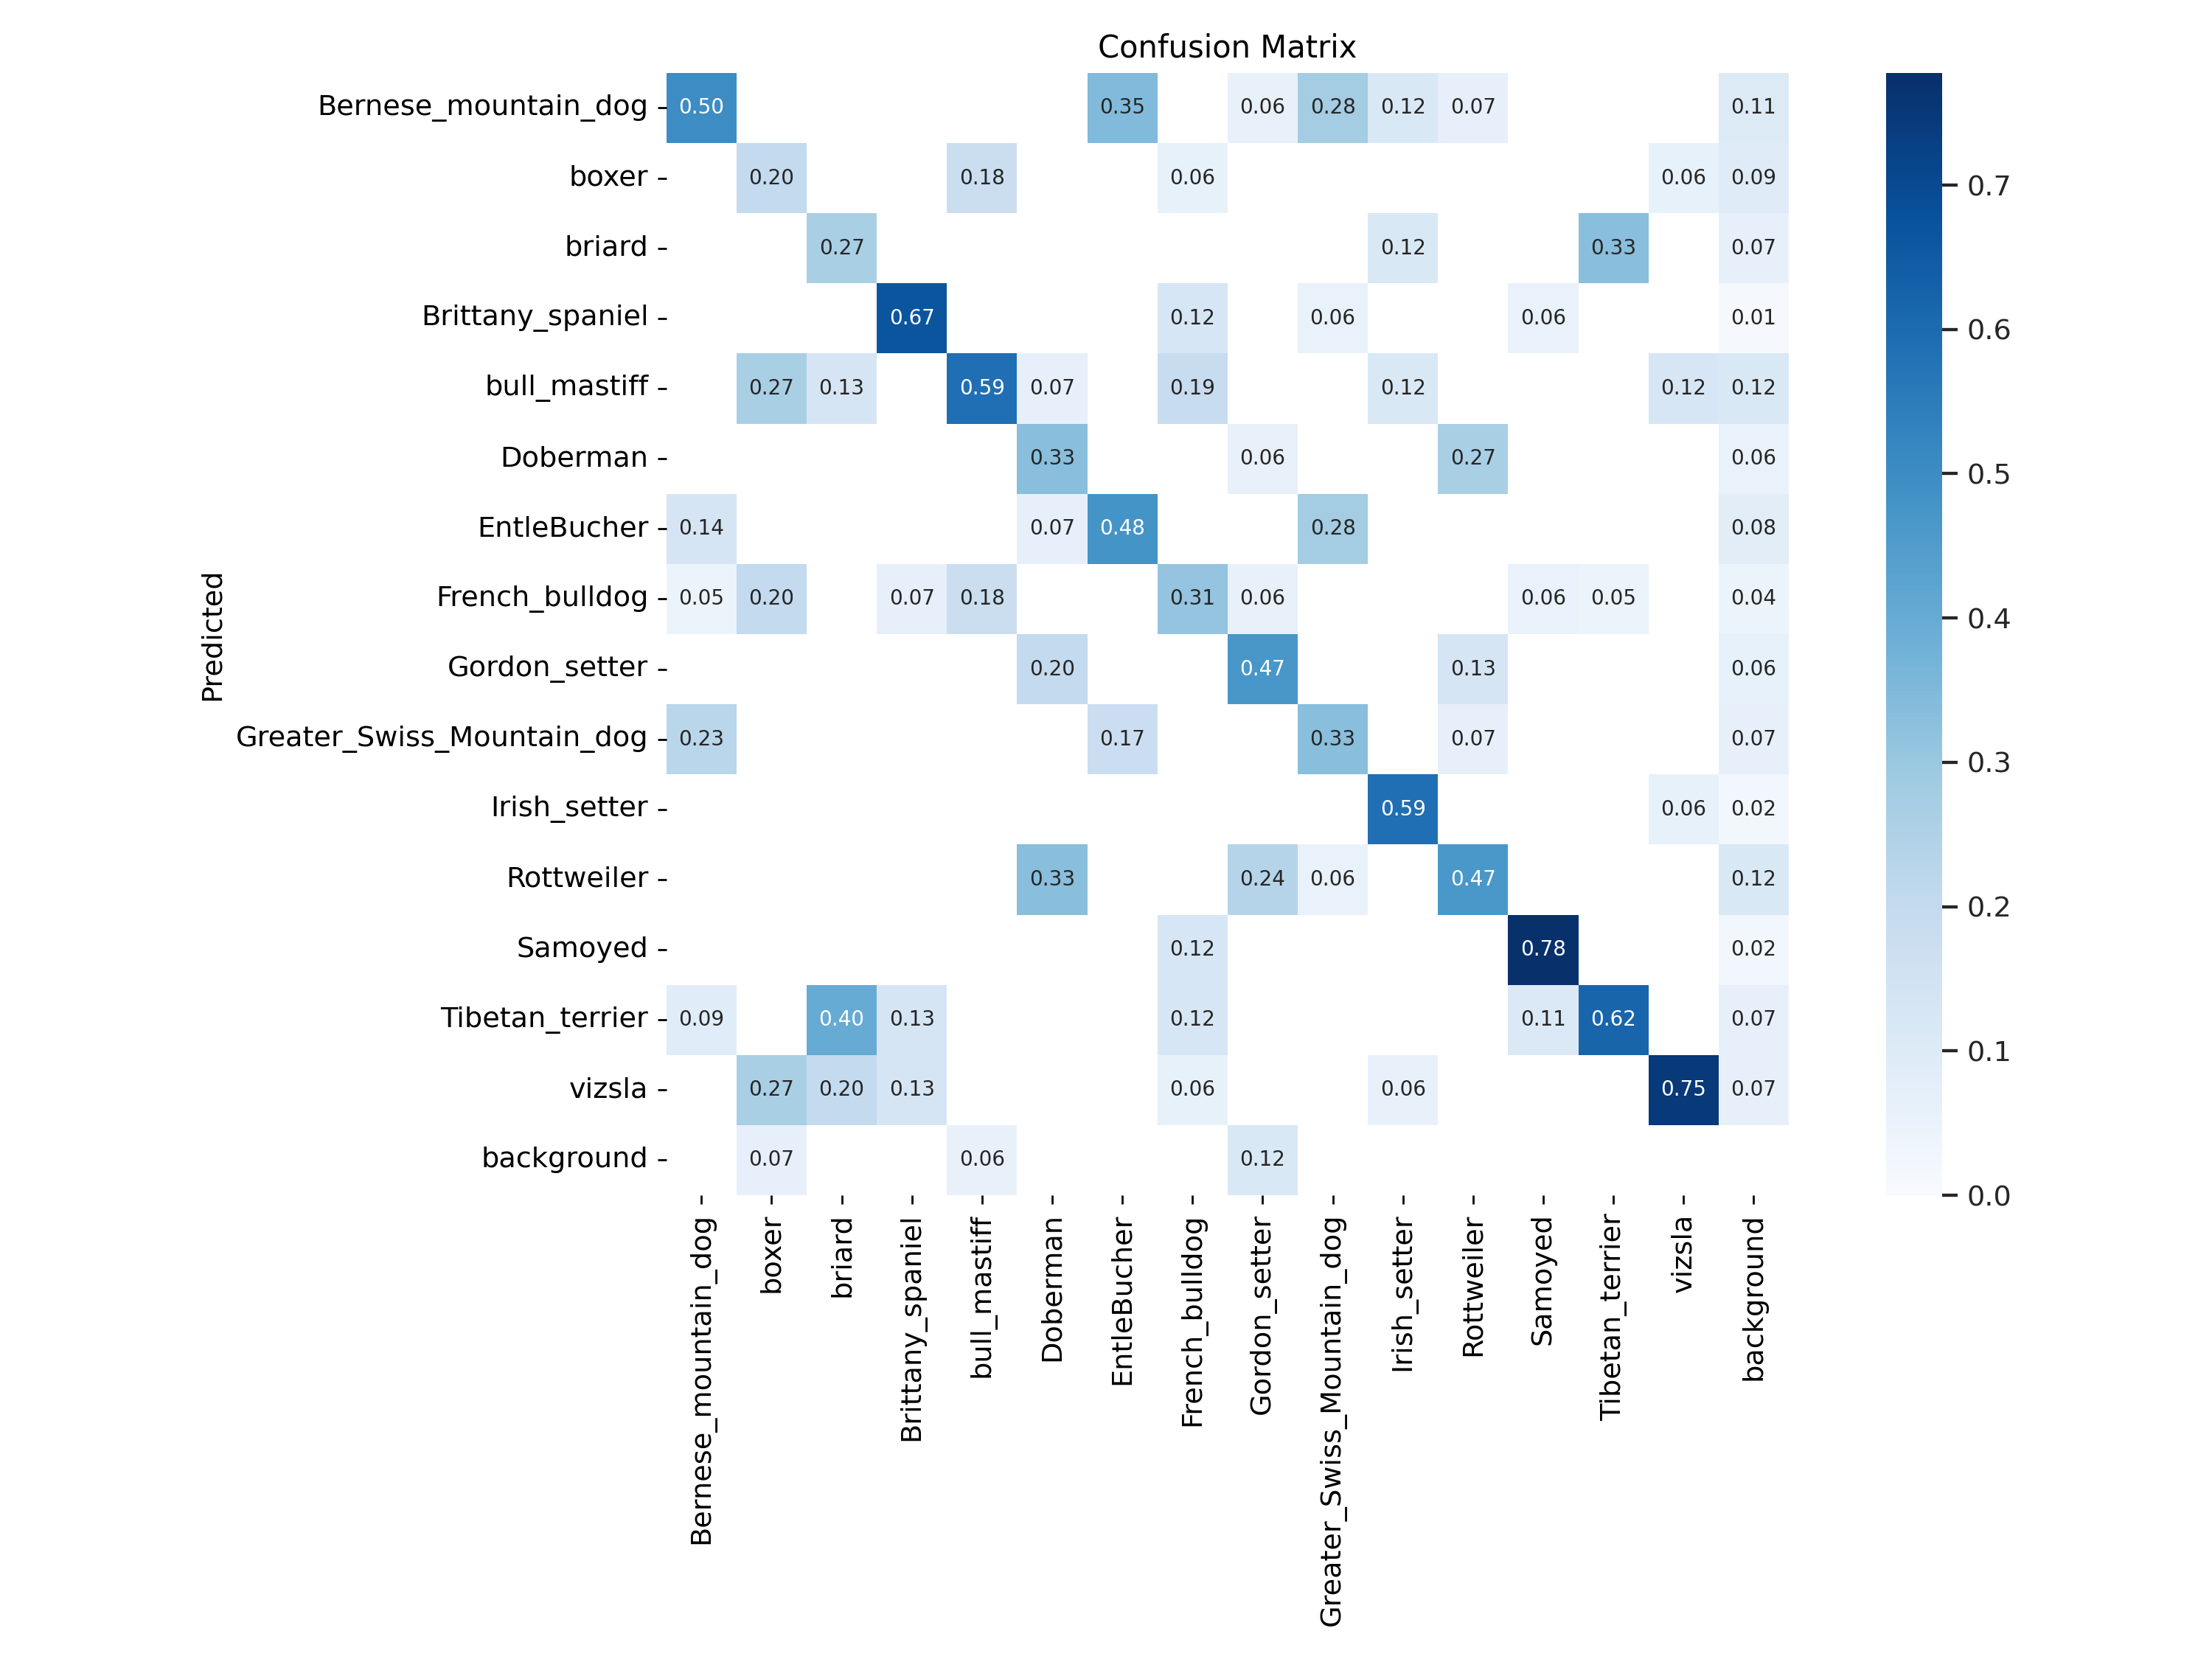

In [ ]:
# Affichage de la matrice de confusion
Image(filename=f"/content/gdrive/MyDrive/P7/yolov9/runs/train/exp4/confusion_matrix.png", width=1000)

### 4.3 Entraînement du modèle avec les images détourées

In [ ]:
!python train_dual.py --workers 8 --batch 10  --img 640 --epochs 70 --data /content/gdrive/MyDrive/P7/yolov9/data.yaml --weights /content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt --device 0 --cfg /content/gdrive/MyDrive/P7/yolov9/models/detect/yolov9_custom.yaml --hyp /content/gdrive/MyDrive/P7/yolov9/data/hyps/hyp.scratch-high.yaml

2024-04-17 20:00:02.570921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 20:00:02.570976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 20:00:02.572384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 20:00:03.640640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train_dual: weights=/content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt, cfg=/content/gdrive/MyDrive/P7/yolov9/models/detect/yolov9_custom.yaml, data=/content/gdrive/MyDrive/P7/yolov9/data.yaml, hyp=/content/gdrive/MyDrive/P7/yolov9/data/hyps/hyp.

### 4.4 Evaluation du modèle

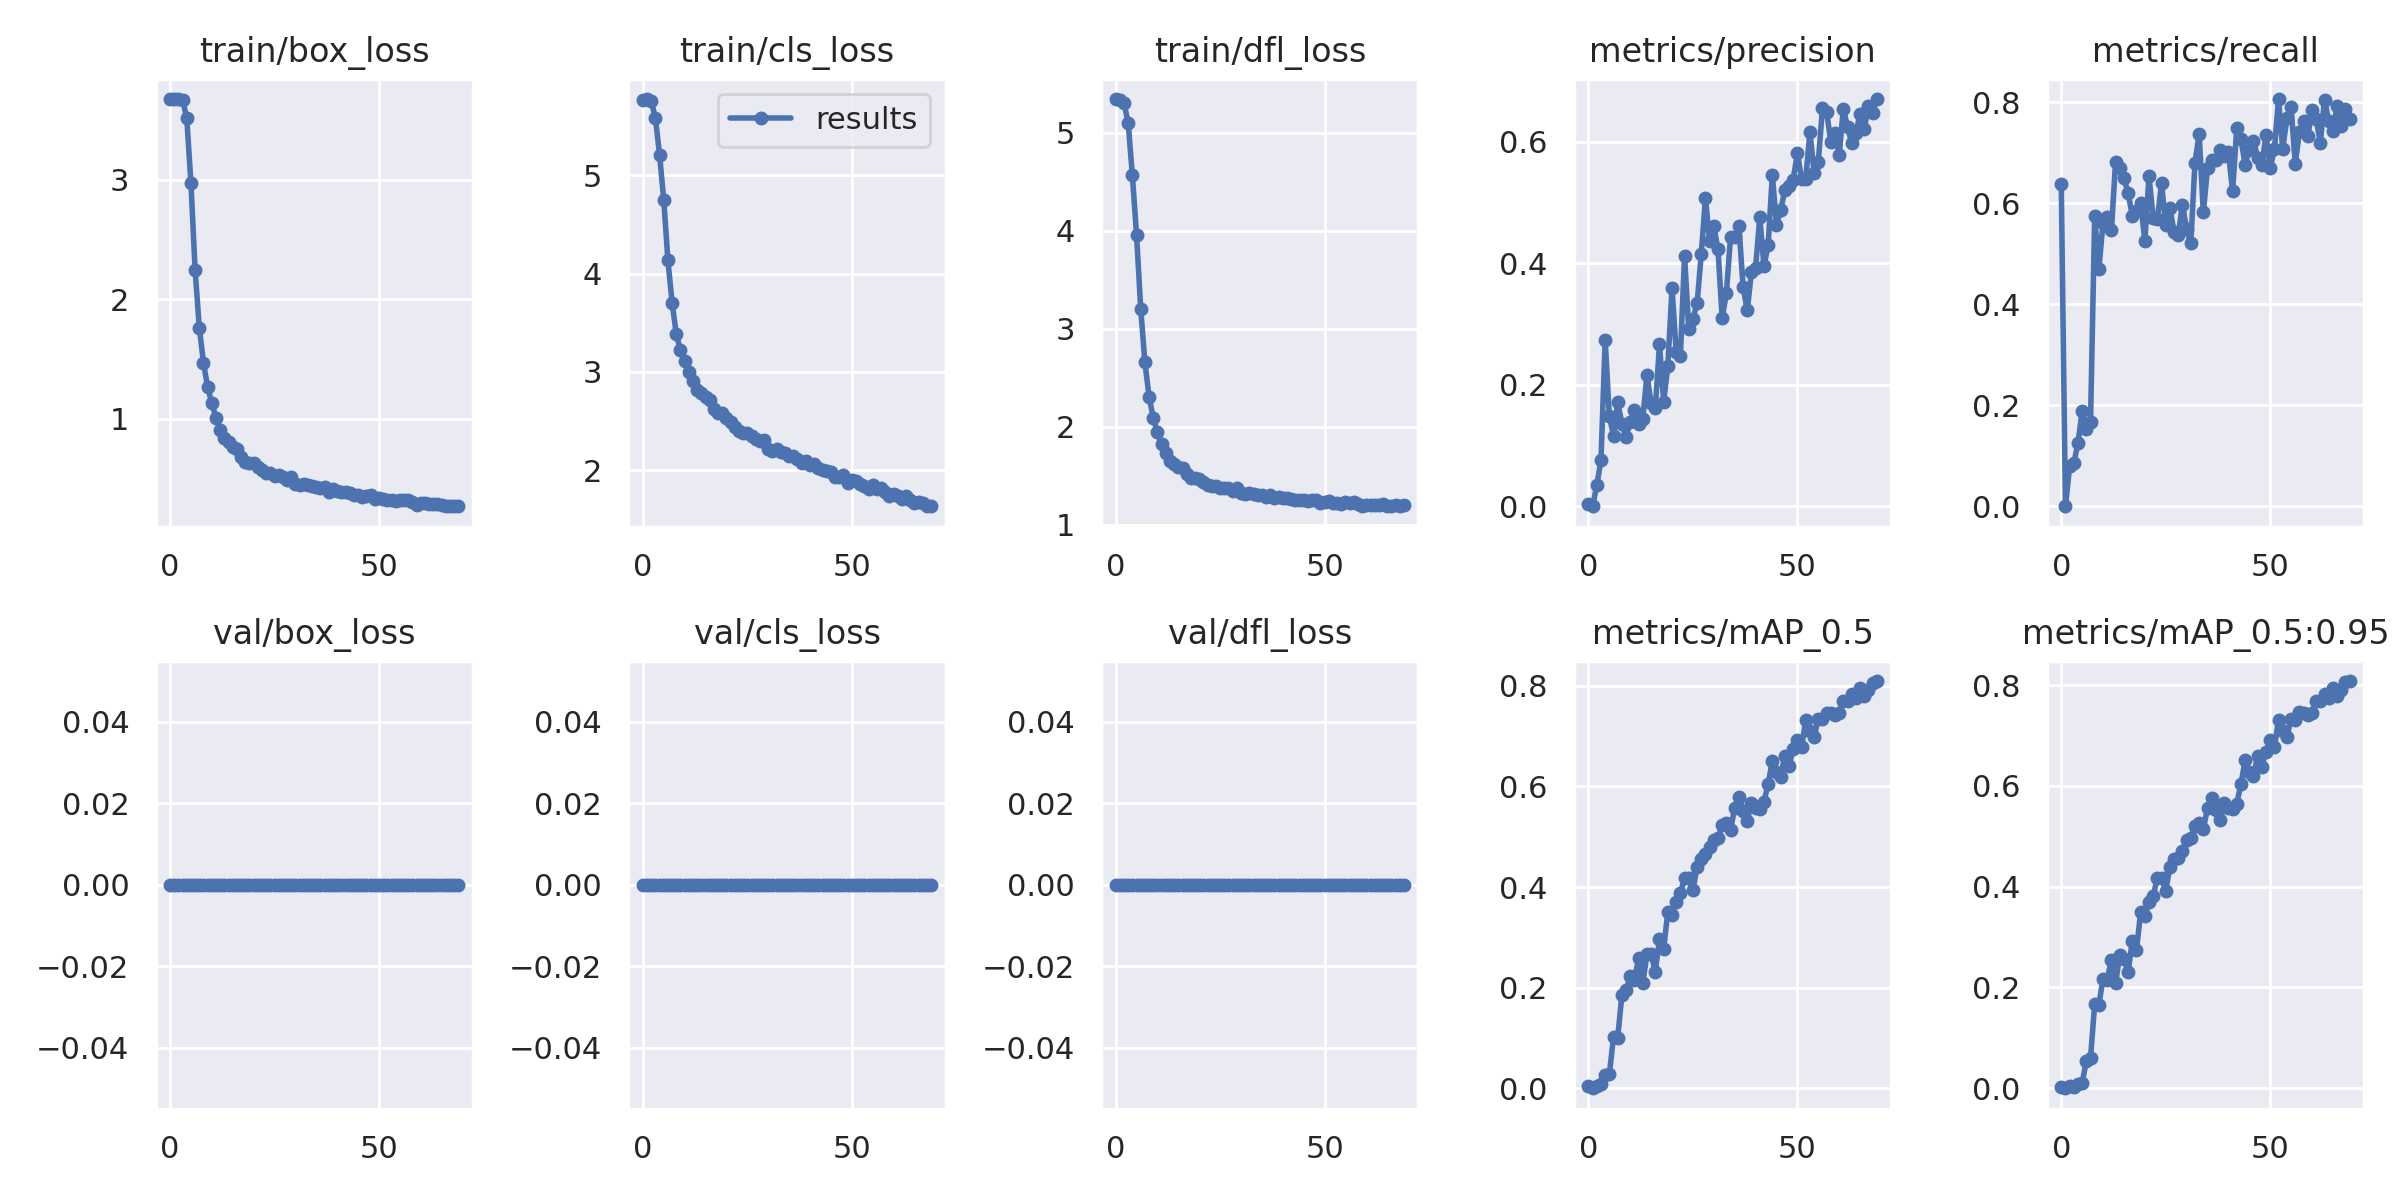

In [ ]:
# Affichage des résultats
Image(filename=f"/content/gdrive/MyDrive/P7/yolov9/runs/train/exp3/results.png", width=1000)

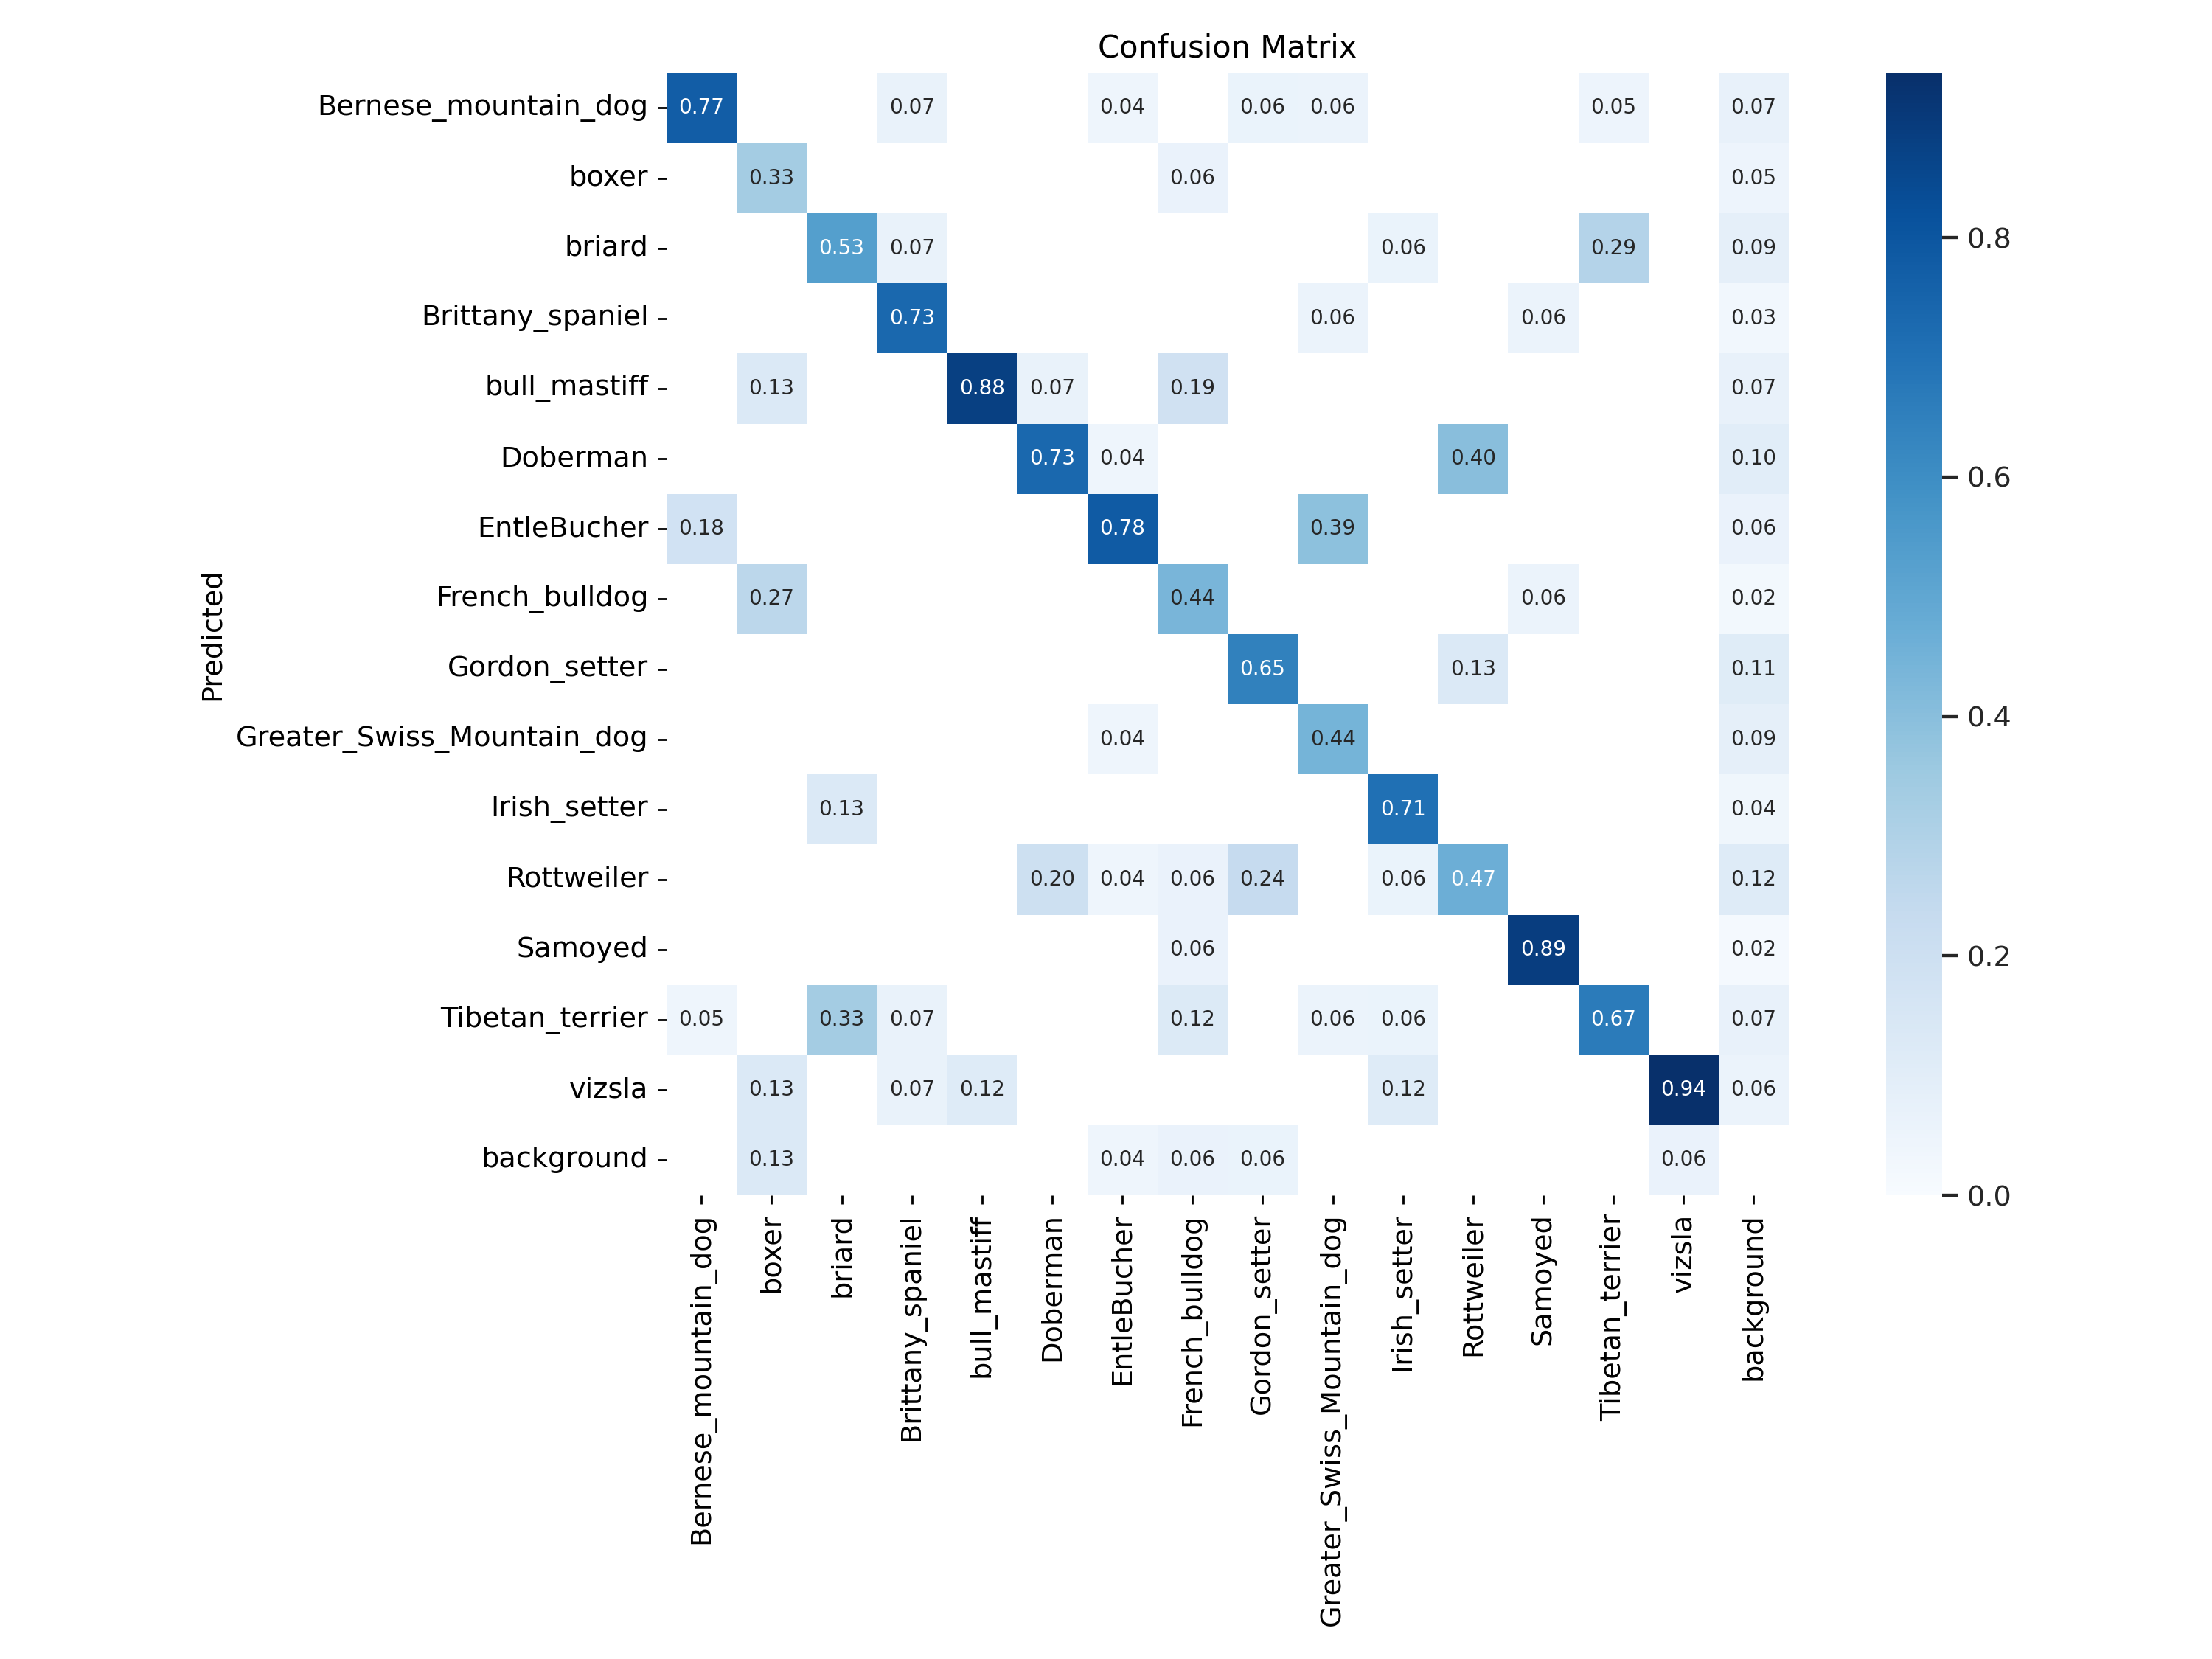

In [ ]:
# Affichage de la matrice de confusion
Image(filename=f"/content/gdrive/MyDrive/P7/yolov9/runs/train/exp3/confusion_matrix.png", width=1000)

### 4.5 Entraînement du modèle sur plus d'épochs

In [ ]:
!python train_dual.py --workers 8 --batch 10  --img 640 --epochs 100 --data /content/gdrive/MyDrive/P7/yolov9/data.yaml --weights /content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt --device 0 --cfg /content/gdrive/MyDrive/P7/yolov9/models/detect/yolov9_custom.yaml --hyp /content/gdrive/MyDrive/P7/yolov9/data/hyps/hyp.scratch-high.yaml

2024-04-18 11:23:23.387338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 11:23:23.387390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 11:23:23.388968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 11:23:24.648405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train_dual: weights=/content/gdrive/MyDrive/P7/yolov9/yolov9-e.pt, cfg=/content/gdrive/MyDrive/P7/yolov9/models/detect/yolov9_custom.yaml, data=/content/gdrive/MyDrive/P7/yolov9/data.yaml, hyp=/content/gdrive/MyDrive/P7/yolov9/data/hyps/hyp.

### 4.6 Evaluation du modèle

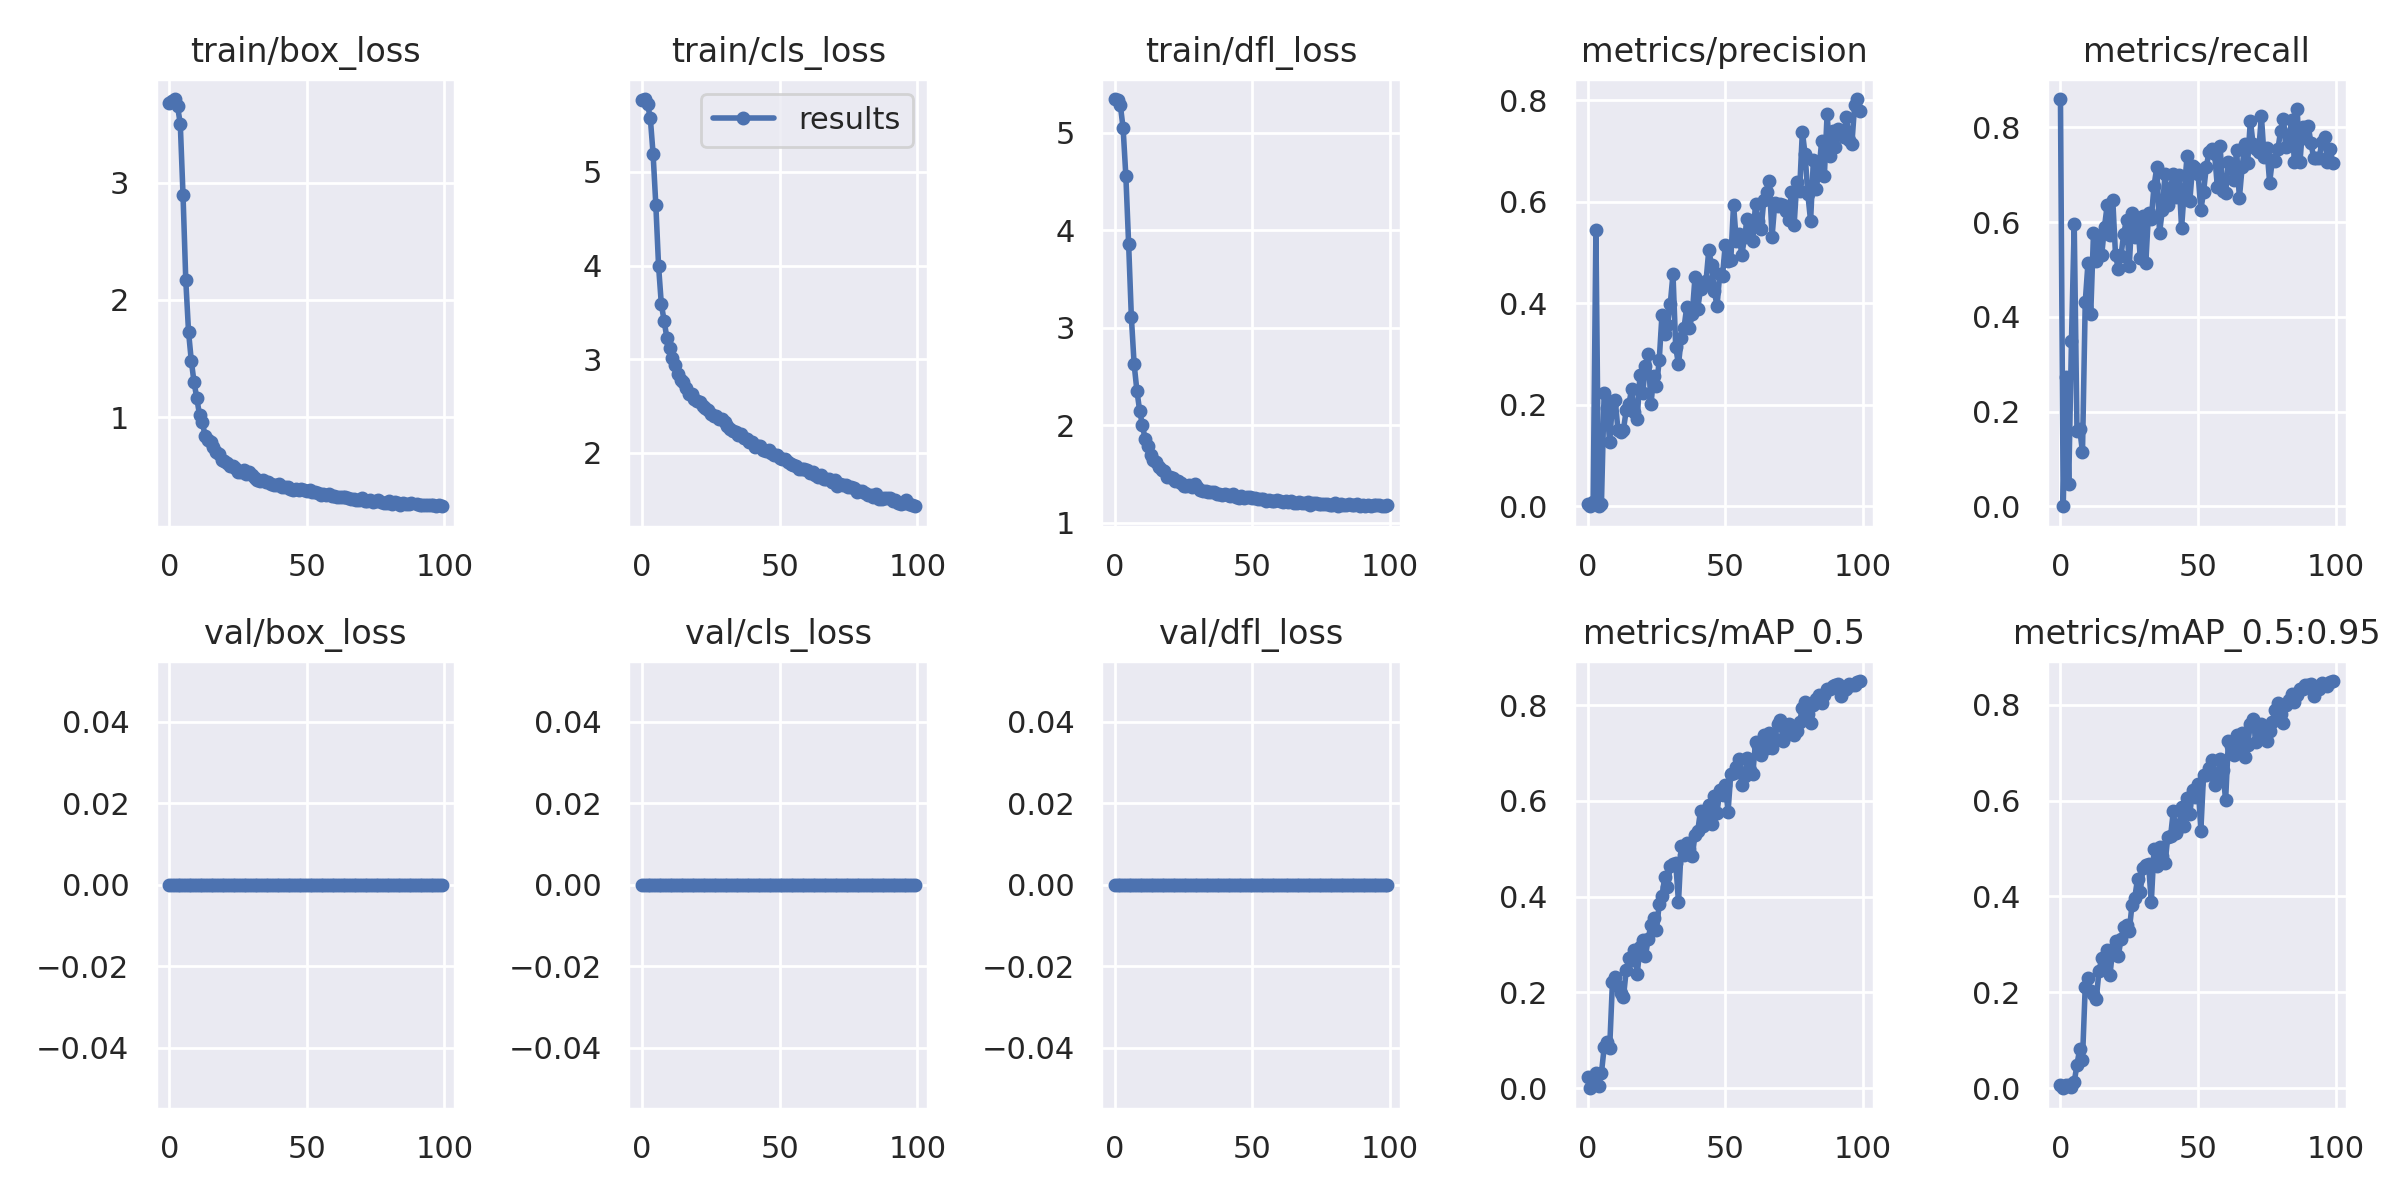

In [ ]:
# Affichage des résultats
Image(filename=f"/content/gdrive/MyDrive/P7/yolov9/runs/train/exp5/results.png", width=1000)

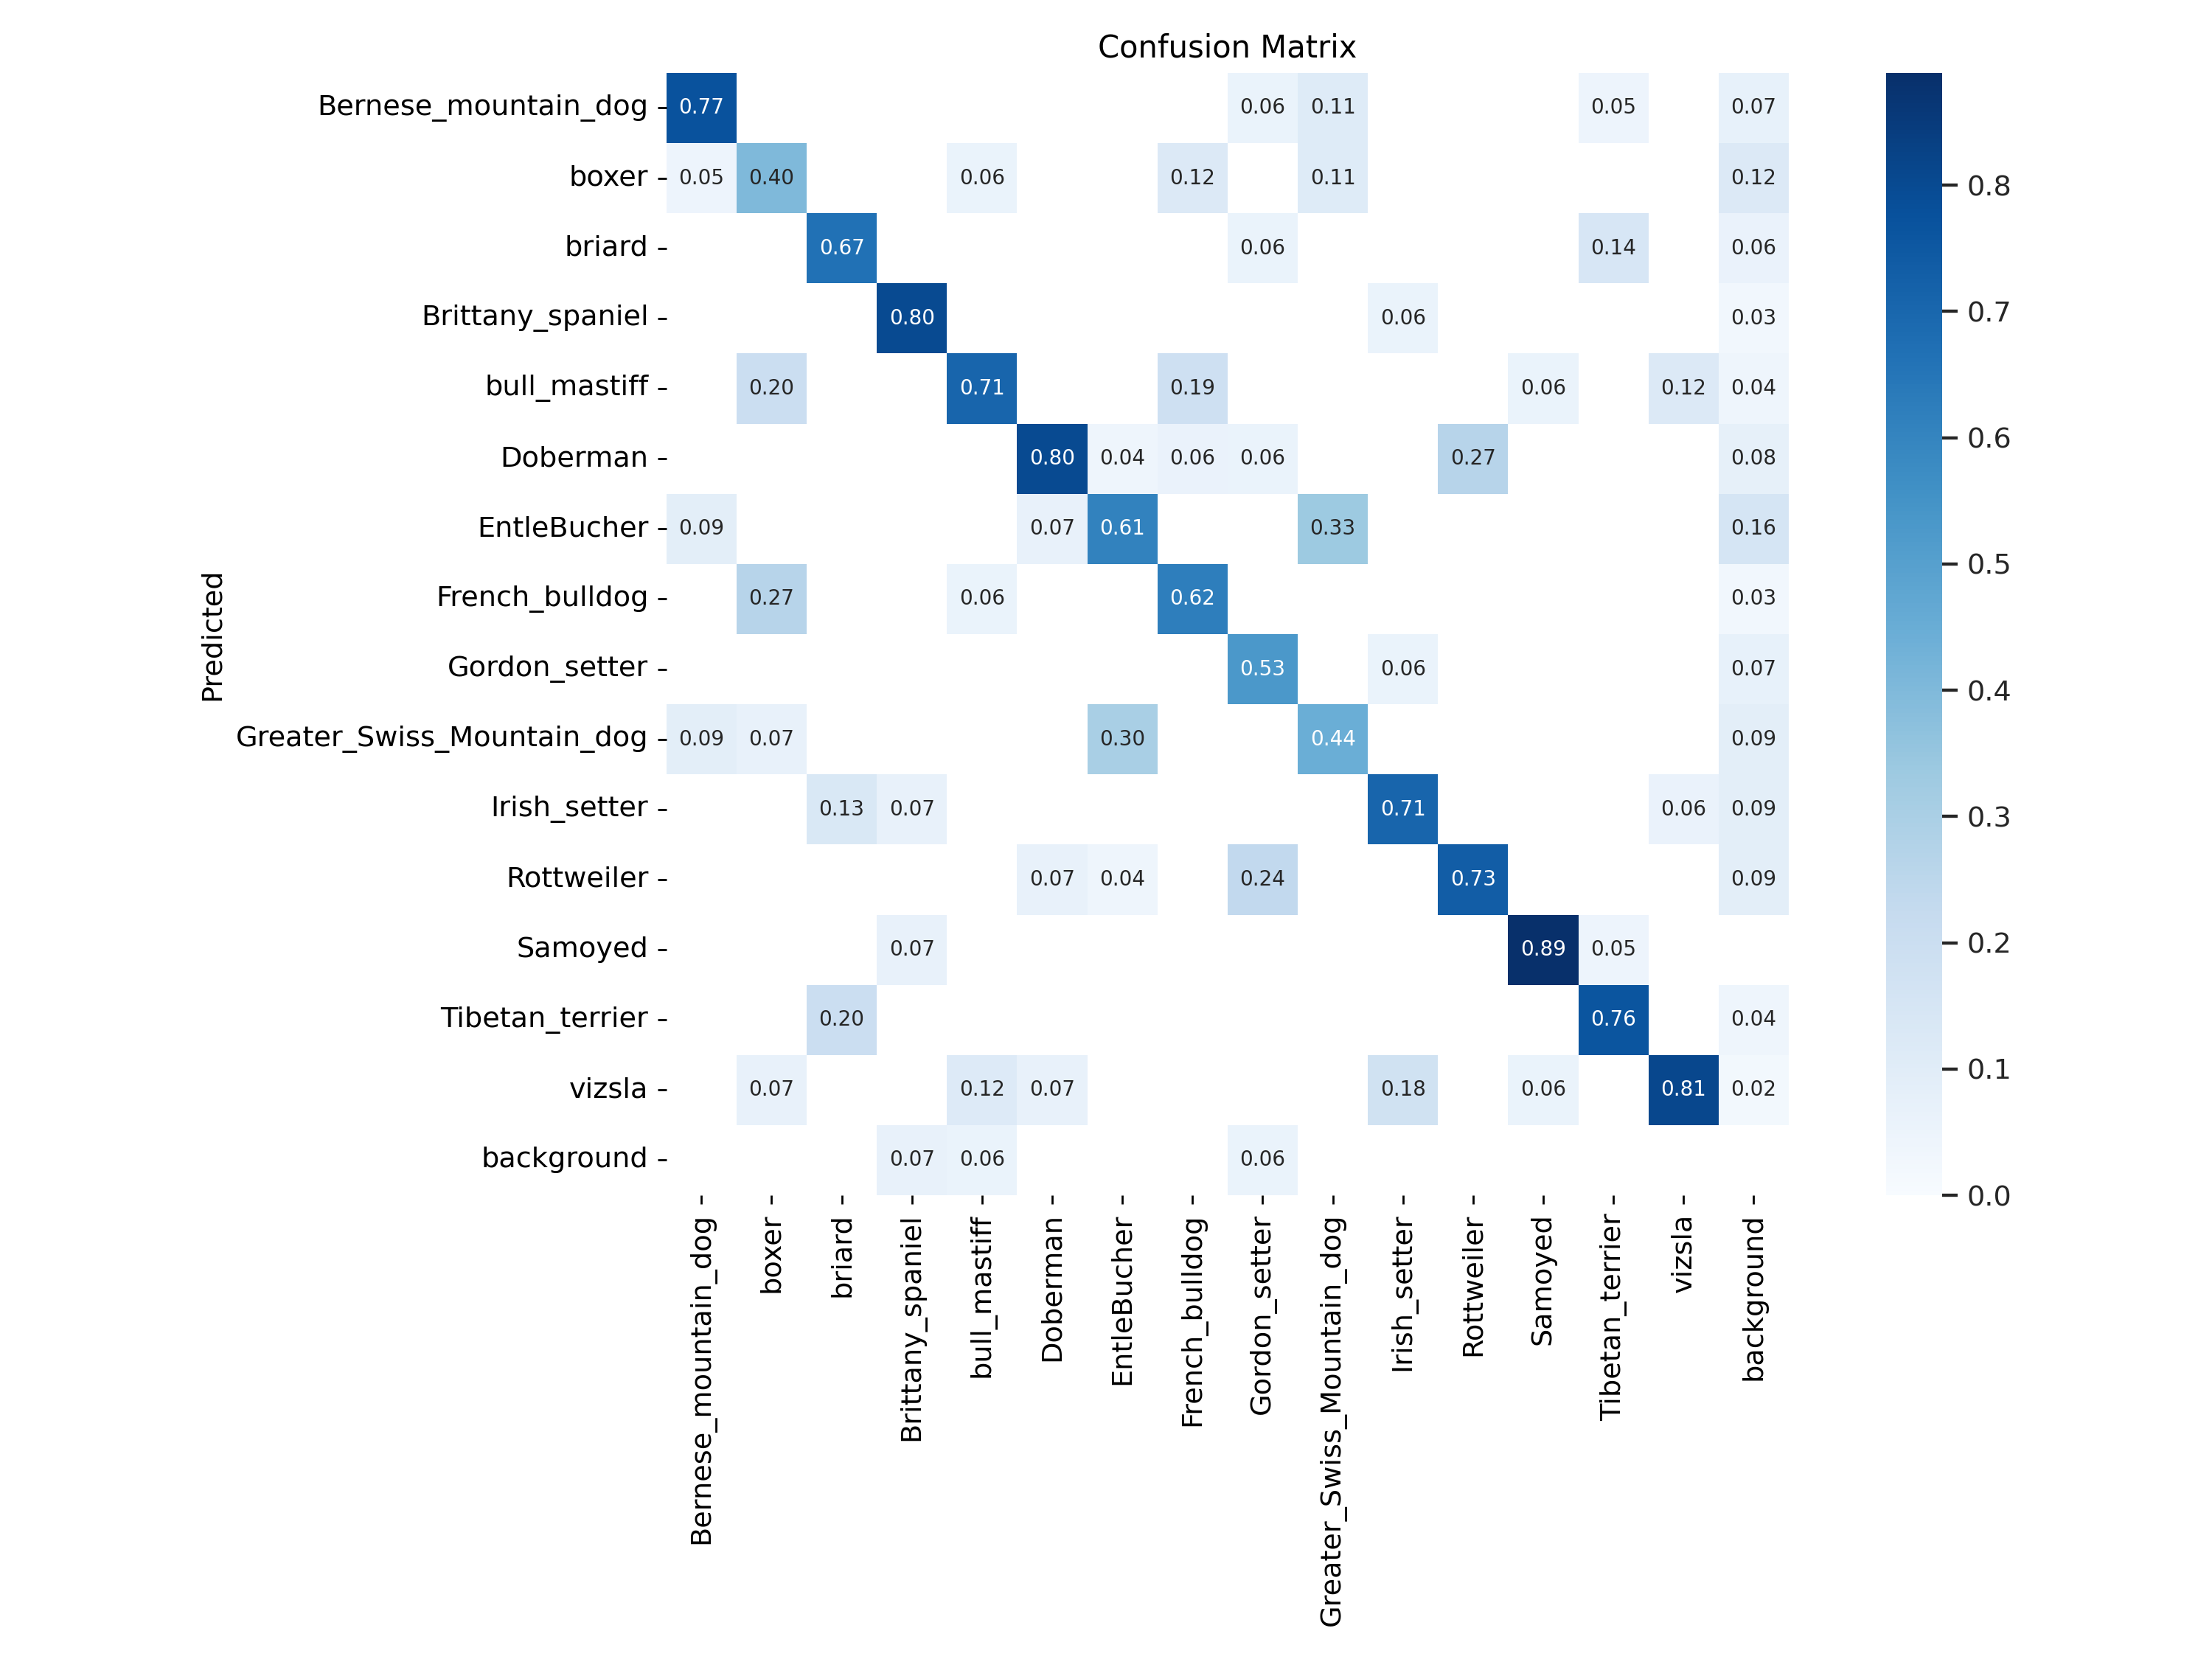

In [ ]:
# Affichage de la matrice de confusion
Image(filename=f"/content/gdrive/MyDrive/P7/yolov9/runs/train/exp5/confusion_matrix.png", width=1000)

## 5. Test du modèle

In [ ]:
# Test du model
!python detect.py \
--img 640 --device 0 \
--weights /content/gdrive/MyDrive/P7/yolov9/runs/train/exp5/weights/best.pt \
--source /content/gdrive/MyDrive/P7/Images_test

detect: weights=['/content/gdrive/MyDrive/P7/yolov9/runs/train/exp5/weights/best.pt'], source=/content/gdrive/MyDrive/P7/Images_test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-88-g03f920b Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
yolov9_custom summary: 580 layers, 60528250 parameters, 0 gradients
image 1/14 /content/gdrive/MyDrive/P7/Images_test/089e1381b697b6394281fcad13bb1c2e.jpg: 640x448 1 vizsla, 199.6ms
image 2/14 /content/gdrive/MyDrive/P7/Images_test/Gordon_setter.jpg: 640x416 1 Bernese_mountain_dog, 113.5ms
image 3/14 /content/gdrive/MyDrive/P7/Images_test/Irish-Red-Setter-Hund-sei

In [ ]:
# Affichage des détections sur des images hors Dataset
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/gdrive/MyDrive/P7/yolov9/runs/detect/exp/*.jpg')[:14]:
      display(Image(filename=image_path, width=300))
      print("\n")

Output hidden; open in https://colab.research.google.com to view.